In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import f1_score
from tensorflow.keras.callbacks import ModelCheckpoint

class NN:
    
    def __init__(self):
        self.model = Sequential()

    def fit(self, X_train, y_train):

        # Standardize the features
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

        # Standardize the features
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)
        
        # Define the filepath for saving the best model
        filepath = 'best_model_temp.h5'

        # Create a ModelCheckpoint callback to monitor validation loss and save the best model
        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', save_best_only=True, mode='min', verbose=1)

        
        num_classes = len(np.unique(y_train))
        y_train_encoded = tf.keras.utils.to_categorical(y_train, num_classes)
        y_val_encoded = tf.keras.utils.to_categorical(y_val, num_classes)

        # Define the neural network model
        self.model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
        self.model.add(Dense(64, activation='relu'))
        self.model.add(Dense(num_classes, activation='softmax'))
        self.classes_ = np.unique(y_train)

        # Compile the model
        self.model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        # Train the model
        self.history = self.model.fit(X_train, y_train_encoded, epochs=15, batch_size=2, verbose=1, validation_data=(X_val, y_val_encoded), callbacks=[checkpoint])
        
        # save the best model over the different epochs
        self.model = tf.keras.models.load_model(filepath)
    def predict(self, X_test):
        scaler = StandardScaler()
        X_test = scaler.fit_transform(X_test)
        predict_x = self.model.predict(X_test) 
        classes_x = np.argmax(predict_x, axis=1)

        return classes_x




In [3]:
from util.functions import impute_and_train

df_numeric =  pd.read_csv('processed/df_numeric.csv')

results = impute_and_train(df_numeric, NN,)

learning with mean imputed data
Cross-validation iteration 1/5
Epoch 1/15


2023-05-21 23:28:25.139590: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


107/112 [===========================>..] - ETA: 0s - loss: 0.3142 - accuracy: 0.8692
Epoch 1: val_loss improved from inf to 0.09452, saving model to best_model_temp.h5
112/112 [==============================] - 0s 2ms/step - loss: 0.3074 - accuracy: 0.8700 - val_loss: 0.0945 - val_accuracy: 1.0000
Epoch 2/15
  1/112 [..............................] - ETA: 0s - loss: 0.1063 - accuracy: 1.0000
Epoch 2: val_loss improved from 0.09452 to 0.03780, saving model to best_model_temp.h5
112/112 [==============================] - 0s 617us/step - loss: 0.0556 - accuracy: 0.9910 - val_loss: 0.0378 - val_accuracy: 1.0000
Epoch 3/15
  1/112 [..............................] - ETA: 0s - loss: 0.0547 - accuracy: 1.0000
Epoch 3: val_loss improved from 0.03780 to 0.02623, saving model to best_model_temp.h5
112/112 [==============================] - 0s 657us/step - loss: 0.0249 - accuracy: 0.9955 - val_loss: 0.0262 - val_accuracy: 1.0000
Epoch 4/15
  1/112 [..............................] - ETA: 0s - loss:

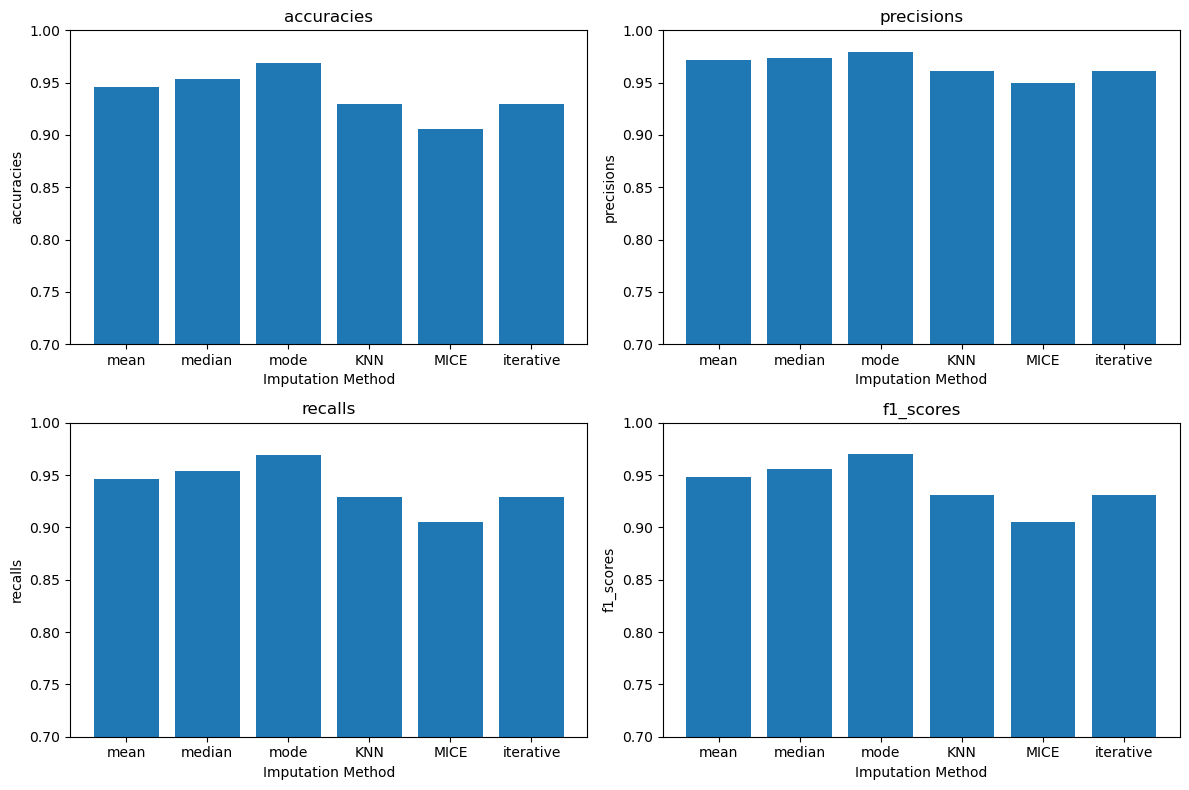

In [4]:
from util.functions import plot_metrics
plot_metrics(results['metrics'])


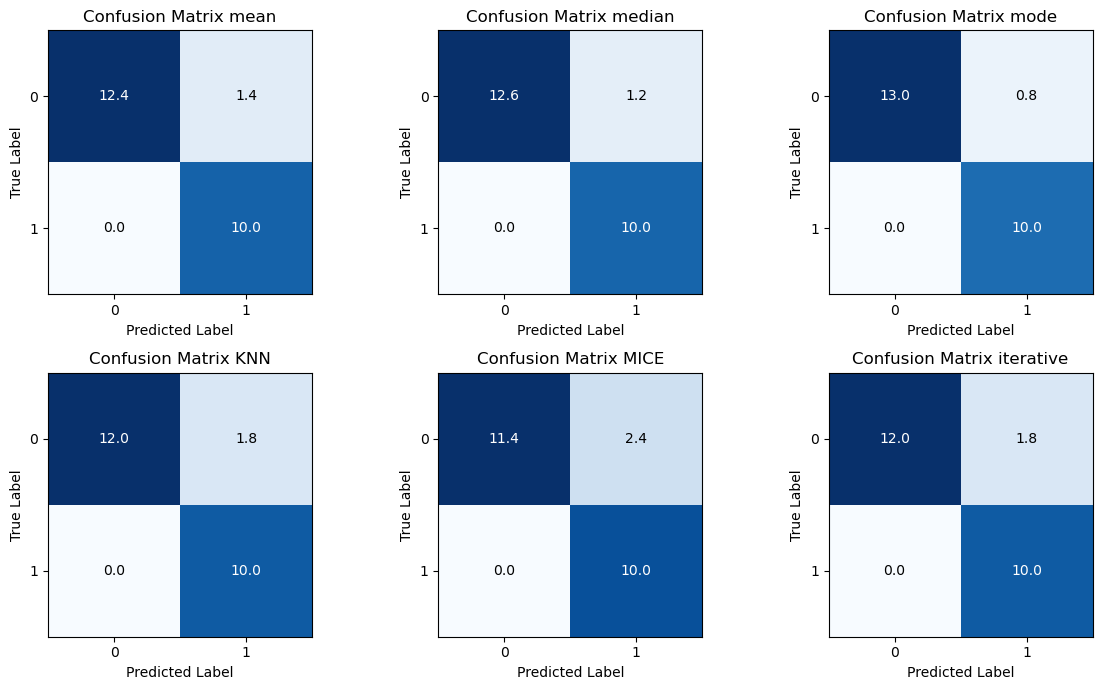

In [5]:
from util.functions import plot_mean_confusion_matrices
plot_mean_confusion_matrices(results['confusion_matrices'])

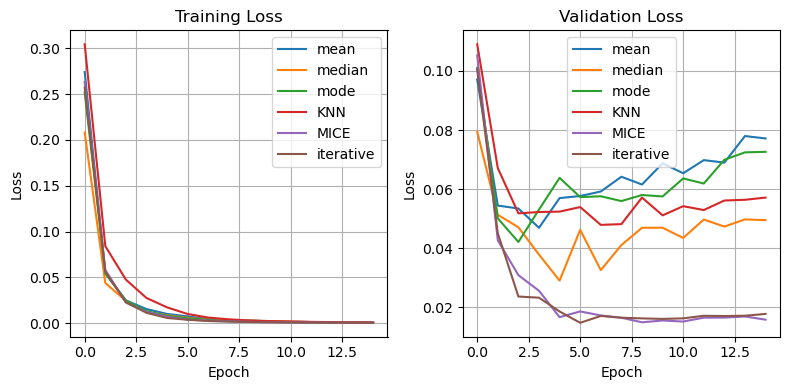

In [6]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

for j, (name, models) in enumerate(results['models'].items()):
    losses = []
    val_losses = []
    for model in models:
        losses.append(model.history.history['loss'])
        val_losses.append(model.history.history['val_loss'])
        
    losses = np.mean(losses, axis=0)
    val_losses = np.mean(val_losses, axis=0)
    
    # Plot training and validation loss
    axs.flat[0].plot(losses)
    axs.flat[1].plot(val_losses)
axs.flat[0].grid()
axs.flat[1].grid()
axs.flat[0].set_xlabel('Epoch')
axs.flat[1].set_xlabel('Epoch')
axs.flat[0].set_ylabel('Loss')
axs.flat[1].set_ylabel('Loss')
axs.flat[0].legend(results['models'].keys())
axs.flat[1].legend(results['models'].keys())
axs.flat[0].set_title('Training Loss')
axs.flat[1].set_title('Validation Loss')

# Add a colorbar and adjust the layout
fig.tight_layout()

# Show the plot
plt.show()

Interpret the weights of the first layer as feature importances

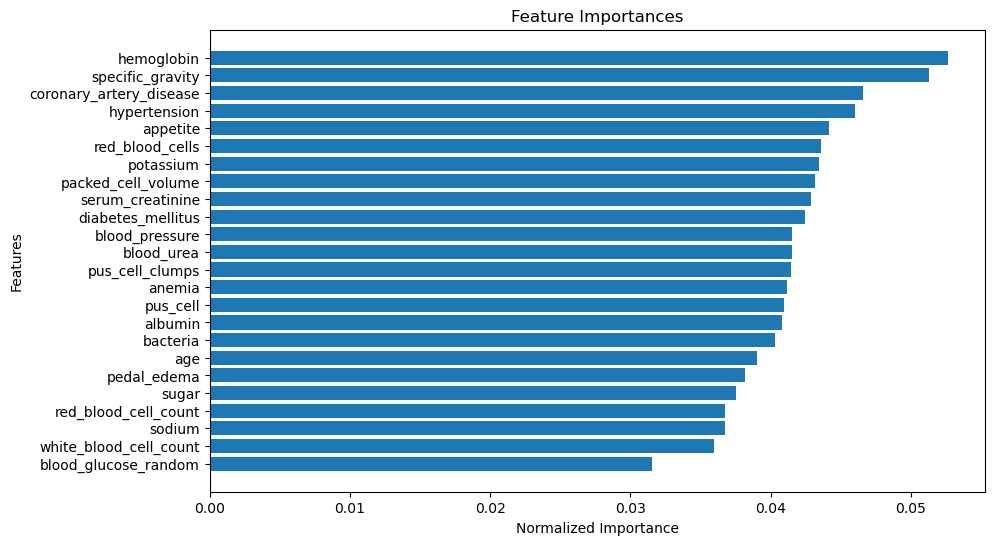

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

df_numeric =  pd.read_csv('processed/df_numeric.csv')
model = results['models']['MICE'][0].model
# Assuming 'model' is your trained neural network model
weights = model.get_weights()

# Compute the absolute sum of weights for each feature
feature_importances = np.abs(weights[0]).sum(axis=1)

# Normalize the feature importances
normalized_importances = feature_importances / np.sum(feature_importances)

# Sort the features and their importances
sorted_indices = np.argsort(normalized_importances)
sorted_importances = normalized_importances[sorted_indices]
sorted_features = df_numeric.columns[sorted_indices]  # Replace with your actual feature names


# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_importances)), sorted_importances)
plt.yticks(range(len(sorted_importances)), sorted_features)
plt.xlabel('Normalized Importance')
plt.ylabel('Features')
plt.title('Feature Importances')
plt.show()


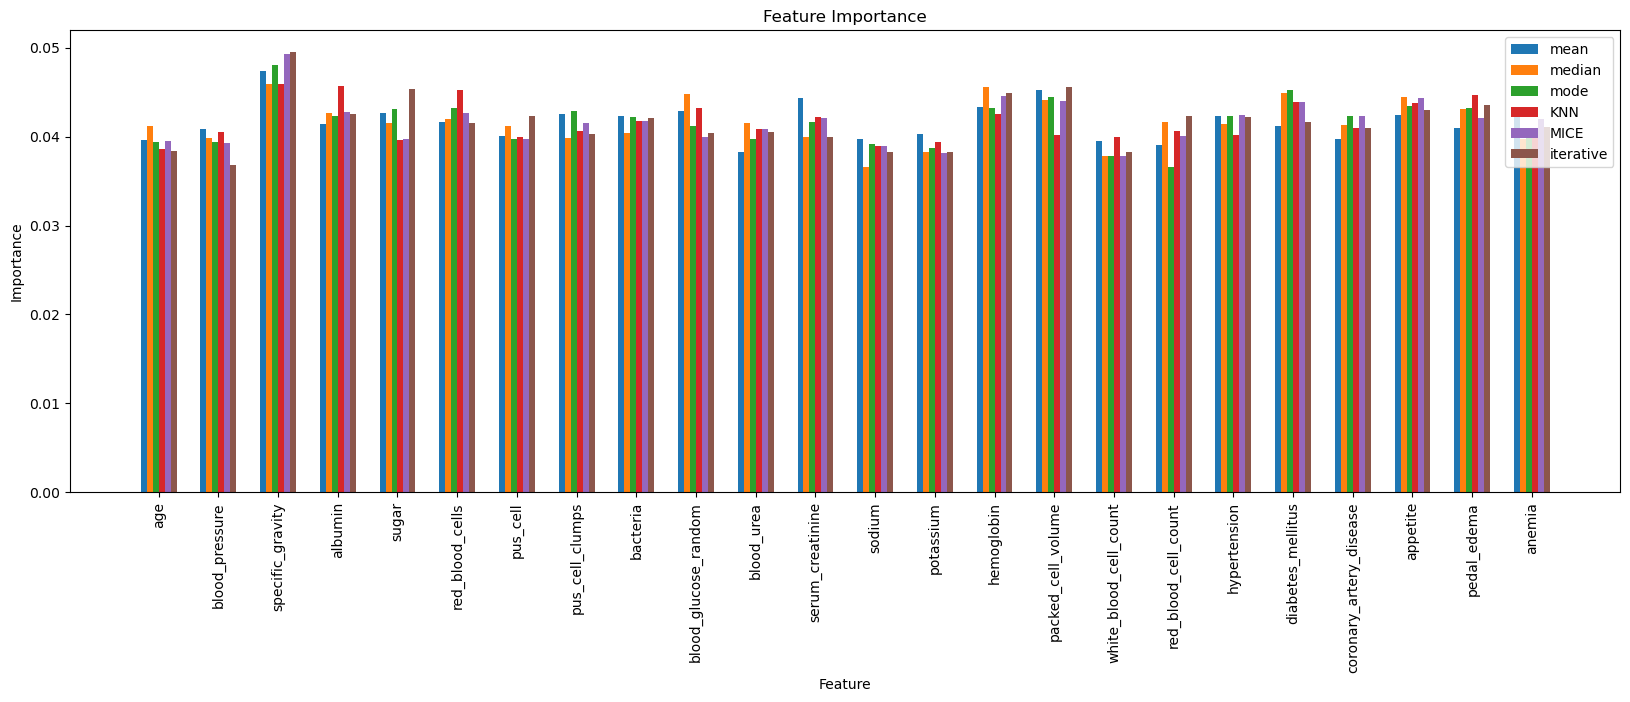

In [23]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from util.functions import plot_feature_importances
import numpy as np
# plot all feature importances as subplots
feature_importances = {}
df_numeric = pd.read_csv('processed/df_numeric.csv')

all_fi = []
for (name, models) in results['models'].items():
    norm_coeff = []
    for nn in models:
        # Assuming 'model' is your trained neural network model
        weights = nn.model.get_weights()

        # Compute the absolute sum of weights for each feature
        fimp = np.abs(weights[0]).sum(axis=1)

        # Normalize the feature importances
        normalized_importances = fimp / np.sum(fimp) 
        norm_coeff.append(normalized_importances)
        all_fi.append(normalized_importances)

    mean = np.mean(norm_coeff, axis=0)
    feature_importances[name] = pd.DataFrame(mean, index=df_numeric.drop(columns=['class']).columns, columns=['Importance'])

all_fi_df = pd.DataFrame(np.mean(all_fi, axis=0), index=df_numeric.drop(columns=['class']).columns, columns=['Importance'])
all_fi_df.to_csv('results/feature_importances_neural_network.csv', index=True)
plot_feature_importances(feature_importances)